In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sainehapadala","key":"77a8153ec1168226e31076adc9f3d698"}'}

In [5]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c cs-480-2024-spring
!unzip cs-480-2024-spring.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train_images/196207162.jpeg  
  inflating: data/train_images/196207164.jpeg  
  inflating: data/train_images/196207198.jpeg  
  inflating: data/train_images/196207403.jpeg  
  inflating: data/train_images/196207539.jpeg  
  inflating: data/train_images/196207572.jpeg  
  inflating: data/train_images/196207729.jpeg  
  inflating: data/train_images/196207888.jpeg  
  inflating: data/train_images/196208355.jpeg  
  inflating: data/train_images/196208682.jpeg  
  inflating: data/train_images/196208848.jpeg  
  inflating: data/train_images/196209074.jpeg  
  inflating: data/train_images/196209078.jpeg  
  inflating: data/train_images/196209236.jpeg  
  inflating: data/train_images/196209887.jpeg  
  inflating: data/train_images/196209889.jpeg  
  inflating: data/train_images/196209960.jpeg  
  inflating: data/train_images/196210323.jpeg  
  inflating: data/train_images/196211220.jpeg  
  inflating: data/train_images/196211

In [3]:
import torch
import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import xgboost as xgb
from tqdm.notebook import tqdm

In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
batch_size = 5
learning_rate = 2e-4
num_of_epochs = 10
ROOT_PATH = "/content/data/"

In [11]:
# Custom Dataset for Loading Images and Ancillary Data
class PlantDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpeg")
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        if self.transform:
            image = self.transform(image=image)["image"]
        ancillary_data = self.df.iloc[idx, :164].values.astype('float32')
        labels = self.df.iloc[idx, -6:].values.astype('float32')
        return image, ancillary_data, labels

# Transform for images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Augmentation and normalization for training
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomResizedCrop(height=224, width=224, p=1.0),
    A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.5),
    A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255),
    ToTensorV2(),
])

# Normalization for testing
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255),
    ToTensorV2(),
])

# Load Data
train_dataset = PlantDataset(
    img_dir=ROOT_PATH + 'train_images',
    csv_file=ROOT_PATH + 'train.csv',
    transform=train_transform
)

test_dataset = PlantDataset(
    img_dir=ROOT_PATH + 'test_images',
    csv_file=ROOT_PATH + 'test.csv',
    transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [12]:
# Model definition
class PlantNet(nn.Module):
    def __init__(self):
        super(PlantNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(2048 + 164, 512)  # 2048 for ResNet output, 164 for ancillary data
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 6)  # 6 traits

    def forward(self, image, ancillary_data):
        img_features = self.resnet(image)
        combined = torch.cat((img_features, ancillary_data), dim=1)
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the feature extractor model
feature_extractor = PlantNet().to(device)
feature_extractor.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PlantNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [13]:

def extract_features(loader, model):
    features = []
    labels_list = []
    with torch.no_grad():
        for images, ancillary_data, labels in loader:
            images, ancillary_data = images.to(device), ancillary_data.to(device)
            outputs = model(images, ancillary_data)
            features.append(outputs.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

train_features, train_labels = extract_features(train_loader, feature_extractor)
test_features, _ = extract_features(test_loader, feature_extractor)

# XGBoost

In [14]:

# Train XGBoost on extracted features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(train_features, train_labels)

xgb_model.save_model('xgboost_model.json')

# Predict on the test set using XGBoost
test_predictions = xgb_model.predict(test_features)

# Combine predictions
submission_df = pd.DataFrame(test_predictions, columns=['X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
submission_df.insert(0, 'id', test_dataset.df['id'])  # Assuming 'id' is the first column in your CSV file

submission_df.to_csv("submissionRESTNETXGBV1.csv", index=False)

R² score for trait X1: -180.4251269264612
R² score for trait X2: -0.05263015873776378
R² score for trait X3: -0.06707413604049739
R² score for trait X4: 0.013324554881496309
R² score for trait X5: -10.03012597522083
R² score for trait X6: 0.023402136267101525


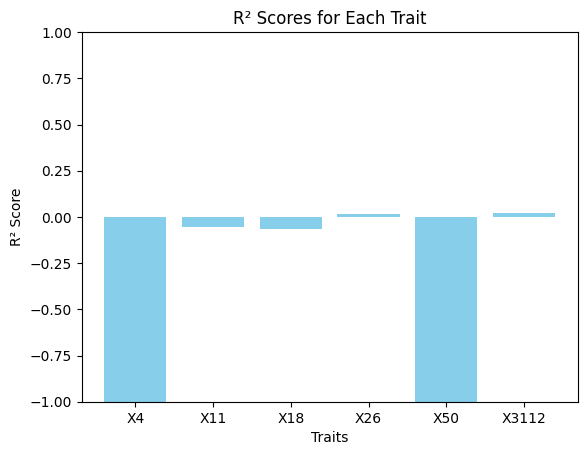

In [16]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_features, val_features, train_labels, val_labels = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(train_features, train_labels)

val_predictions = xgb_model.predict(val_features)

r2_scores = []
for i in range(val_labels.shape[1]):
    r2 = r2_score(val_labels[:, i], val_predictions[:, i])
    r2_scores.append(r2)
    print(f"R² score for trait X{i+1}: {r2}")

# Plot R² scores for each trait
traits = ['X4', 'X11', 'X18', 'X26', 'X50', 'X3112']
plt.bar(traits, r2_scores, color='skyblue')
plt.xlabel('Traits')
plt.ylabel('R² Score')
plt.title('R² Scores for Each Trait')
plt.ylim(-1, 1)  # R² scores can be negative if the model is worse than the mean model
plt.show()
